# Import libraries

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import scipy
import pathlib
import h5py
import datetime
from pathlib import Path
from scipy.signal import filtfilt
import matplotlib.ticker as ticker
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
from typing import Optional, Tuple, Dict, Callable, Union
from functools import partial

from scipy import stats

# Functions

In [2]:
def response_side(df: pd.DataFrame) -> None:
    """
    Assign ipsilateral/contralateral response side based on protocol and hemisphere.
    """
    conditions = [
        (df['hemisphere'] == 'L') & df['protocol'].str.startswith('L'),
        (df['hemisphere'] == 'L') & df['protocol'].str.startswith('R'),
        (df['hemisphere'] == 'R') & df['protocol'].str.startswith('R'),
        (df['hemisphere'] == 'R') & df['protocol'].str.startswith('L')
    ]
    choices = ['I_L', 'C_L', 'I_R', 'C_R']
    df['resp_side'] = np.select(conditions, choices, default='Unknown')

def group_signal(
    df: pd.DataFrame, stim_type: str, state: str = 'Awake', response_side_start: str = 'C'
) -> pd.DataFrame:
    """
    Filters and groups signal data for specific stim and state.
    """
    df_filtered = df[
        (df['resp_side'].str.startswith(response_side_start)) &
        (df['stim_type'] == stim_type) &
        (df['state'] == state)
    ].reset_index(drop=True)

    df_filtered['sstim_id'] = df_filtered.index + 1
    return df_filtered.groupby(['stim_type', 'mouse', 'sstim_id']).mean(numeric_only=True).copy()


def data_for_plot(
    df: pd.DataFrame,
    stype: str = 'HbT',
    ref_df: Optional[pd.DataFrame] = None,
    detrend: bool = False,
    detrend_time: float = 15.0,
    detrend_threshold: float = -10.0,
    multiplier: float = 100,
    multiplier2: float = 1e6,
    baseline_frames: int = 20,
    detrend_s: float = 1e6,
    smoothing: Optional[str] = None,
    smoothing_params: Optional[dict] = None
) -> pd.DataFrame:
    """
    Prepares time series data for plotting with optional detrending, baseline subtraction, 
    scaling, and smoothing.

    Args:
        df (pd.DataFrame): Main DataFrame with MultiIndex (stim_type, mouse, sstim_id) and transposed time series.
        stype (str, optional): Signal type label (e.g., 'HbT', 'Ca'). Defaults to 'HbT'.
        ref_df (Optional[pd.DataFrame], optional): Reference DataFrame for conditional detrending. Defaults to None.
        detrend (bool, optional): Whether to apply spline-based detrending if reference trace is below threshold. Defaults to False.
        detrend_time (float, optional): Time (in seconds) to evaluate condition for detrending. Defaults to 15.0.
        detrend_threshold (float, optional): Threshold in reference trace to trigger detrending. Defaults to -10.0.
        multiplier (float, optional): Scaling factor for the main trace. Defaults to 100.
        multiplier2 (float, optional): Scaling factor for the reference trace. Defaults to 1e6.
        baseline_frames (int, optional): Number of frames at the beginning used for baseline subtraction. Defaults to 20.
        detrend_s (float, optional): Spline smoothing factor for detrending. Defaults to 1e6.
        smoothing (Optional[str], optional): Type of smoothing to apply. Options: 'savgol', 'moving_average'. Defaults to None.
        smoothing_params (Optional[dict], optional): Parameters for smoothing (e.g., window_length, polyorder). Defaults to None.

    Returns:
        pd.DataFrame: Concatenated DataFrame with columns ['Time', 'Signal', 'S_type', 'stim_type', 'mouse', 'sstim_id', 'Detrend'].
    """
    time = df.T.iloc[:, 0].index.astype(np.float32)
    all_data = []

    for (stim_type, mouse, sstim_id) in df.index:
        trace = df.T.loc[:, (stim_type, mouse, sstim_id)].values.astype(float)

        # Conditional detrending based on reference DataFrame
        apply_detrend = False
        if (ref_df is not None) and ((stim_type, mouse, sstim_id) in ref_df.index):
            ref_trace = ref_df.T.loc[:, (stim_type, mouse, sstim_id)].values.astype(float) * multiplier2
            mask = time <= detrend_time
            if np.any(ref_trace[mask] <= detrend_threshold):
                apply_detrend = detrend

        # Scale signal
        trace *= multiplier

        # Apply spline detrending if condition is met
        if apply_detrend:
            spline = UnivariateSpline(time, trace, s=detrend_s)
            trace = trace - spline(time)

        # Subtract baseline
        if baseline_frames > 0 and len(trace) >= baseline_frames:
            trace = trace - np.mean(trace[:baseline_frames])

        # Apply smoothing
        if smoothing == 'savgol':
            params = smoothing_params or {}
            wl = params.get('window_length', 11)
            if wl % 2 == 0:
                wl += 1
            po = params.get('polyorder', 3)
            trace = savgol_filter(trace, window_length=wl, polyorder=po)
        elif smoothing == 'moving_average':
            window_size = (smoothing_params or {}).get('window_size', 5)
            trace = np.convolve(trace, np.ones(window_size) / window_size, mode='same')

        all_data.append(pd.DataFrame({
            'Time': time,
            'Signal': trace,
            'S_type': stype,
            'stim_type': stim_type,
            'mouse': mouse,
            'sstim_id': sstim_id,
            'Detrend': apply_detrend
        }))

    return pd.concat(all_data, ignore_index=True)

def align_yaxis(ax1, v1, ax2, v2):
    """Align v1 in ax1 to match v2 in ax2 visually."""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    adjust_yaxis(ax2, (y1 - y2) / 2, v2)
    adjust_yaxis(ax1, (y2 - y1) / 2, v1)

def adjust_yaxis(ax, ydiff, v):
    """Adjust y-limits to maintain a fixed data point location."""
    inv = ax.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, ydiff))
    miny, maxy = ax.get_ylim()
    miny -= v
    maxy -= v

    if -miny > maxy or (-miny == maxy and dy > 0):
        nminy = miny
        nmaxy = miny * (maxy + dy) / (miny + dy)
    else:
        nmaxy = maxy
        nminy = maxy * (miny + dy) / (maxy + dy)

    ax.set_ylim(nminy + v, nmaxy + v)


def plot_single_panel_signals_df(
    data_for_plot_fn_ca,
    data_for_plot_fn_hbt,
    ca_df, ca_corr_df,
    dhbo_df=None, dhbr_df=None, dhbt_df=None,
    stim_type=None, state=None,
    stim_label='Stimulus',
    x_label='Time (s)',
    y_ca='ΔF/F₀ Ca²⁺ (%)',
    y_hb='Δ[Hb] (μM)',
    label_position='center',
    error_type='se',
    exclude_mice=None,
    color_dict=None,
    error_alpha=0.1,
    label_y_fracs=None,
    label_x_fracs=None,
    y1_lim=None,
    y2_lim=None,
    x_lim=None,
    y1_color='green',
    y2_color='red',
    y1_label_color='green',
    y2_label_color='red',
    x_offsets_sec=None,
    ann_fontsize=15,
    annotate_stimulus=True,
    y_stim_ann=(0.85, 0.95),
    stim_box_x=2.0,
    stim_arrow_color='darkgray',
    stim_box_edge_color='darkgray',
    stim_box_face_color='white',
    stim_text_color='darkgray',
    x_tick_step=None,
    y1_tick_step=None,
    y2_tick_step=None,
    save_path: Path = None
):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax2 = ax.twinx()

    if color_dict is None:
        color_dict = {
            'Ca_Raw': 'black',
            'Ca': 'green',
            'HbT': 'magenta',
            'HbO': 'red',
            'HbR': 'blue'
        }

    if label_y_fracs is None:
        label_y_fracs = {
            'Ca_Raw': 0.7,
            'Ca': 0.8,
            'HbT': 0.65,
            'HbO': 0.45,
            'HbR': 0.25
        }

    if label_x_fracs is None:
        label_x_fracs = {
            'Ca_Raw': 0.2,
            'Ca': 0.5,
            'HbT': 0.8,
            'HbO': 0.4,
            'HbR': 0.7
        }

    if x_offsets_sec is None:
        x_offsets_sec = {
            'Ca_Raw': -2,
            'Ca': 0.0,
            'HbT': 2,
            'HbO': -4,
            'HbR': 5
        }

    def plot_signal(df, ref_df, color, ax, label, stype, data_for_plot_fn):
        if df is None or df.empty:
            return None
        if exclude_mice is not None and 'mouse' in df.columns:
            df = df[~df['mouse'].isin(exclude_mice)]
            ref_df = ref_df[~ref_df['mouse'].isin(exclude_mice)]
        if df.empty:
            return None
    
        grouped = group_signal(df, stim_type, state, 'C')
        grouped_ref = group_signal(ref_df, stim_type, state, 'C') if ref_df is not None else None
    
        plot_df = data_for_plot_fn(grouped, stype=stype, ref_df=grouped_ref)
        sns.lineplot(data=plot_df, x="Time", y="Signal", errorbar=error_type, color=color,
                     ax=ax, label=label, legend=False, alpha=1,
                     err_kws={'alpha': error_alpha})
        return plot_df

    ca_wocorr_plot = plot_signal(ca_df, dhbt_df, color_dict['Ca_Raw'], ax, 'Ca_Raw', 'Cawocorr', data_for_plot_fn_ca)
    ca_corr_plot = plot_signal(ca_corr_df, dhbt_df, color_dict['Ca'], ax, 'Ca', 'Ca', data_for_plot_fn_ca)
    dhbt_plot = plot_signal(dhbt_df, dhbt_df, color_dict['HbT'], ax2, 'HbT', 'HbT', data_for_plot_fn_hbt)
    dhbo_plot = plot_signal(dhbo_df, dhbt_df, color_dict['HbO'], ax2, 'HbO', 'HbO', data_for_plot_fn_hbt) if dhbo_df is not None else None
    dhbr_plot = plot_signal(dhbr_df, dhbt_df, color_dict['HbR'], ax2, 'HbR', 'HbR', data_for_plot_fn_hbt) if dhbr_df is not None else None

    plots = [
        (ax, ca_wocorr_plot, 'Ca_Raw'),
        (ax, ca_corr_plot, 'Ca'),
        (ax2, dhbt_plot, 'HbT'),
        (ax2, dhbo_plot, 'HbO'),
        (ax2, dhbr_plot, 'HbR')
    ]

    for ann_ax, plot_df, label in plots:
        if plot_df is None or plot_df.empty:
            continue
        data = plot_df.groupby("Time")["Signal"].mean().reset_index()
        x = data["Time"].values
        y = data["Signal"].values

        x0, x1 = ax.get_xlim() if x_lim is None else x_lim
        x_ann = x0 + label_x_fracs.get(label, 0.5) * (x1 - x0)
        idx = (np.abs(x - x_ann)).argmin()

        y0, y1 = ann_ax.get_ylim()
        y_frac = label_y_fracs.get(label, 0.5)
        y_ann = y0 + y_frac * (y1 - y0)

        x_offset = x_offsets_sec.get(label, 0.0)
        color = color_dict.get(label, 'black')

        ann_ax.annotate(
            label,
            xy=(x[idx], y[idx]),
            xytext=(x_ann + x_offset, y_ann),
            color=color,
            fontsize=ann_fontsize,
            arrowprops=dict(arrowstyle="->", color=color, lw=1.5),
            bbox=dict(boxstyle="round,pad=0.3", fc='white', ec=color, lw=1),
            ha='left', va='center'
        )

    for stim_time in [1, 2, 3, 4]:
        ax.axvspan(stim_time, stim_time + 0.2, facecolor='gray', alpha=0.4, label=stim_label if stim_time == 1 else None)

    if annotate_stimulus:
        y0, y1 = ax.get_ylim()
        stim_y = y0 + y_stim_ann[1] * (y1 - y0)
        stim_text_x = stim_box_x
        stim_text_y = stim_y
        for i, stim_time in enumerate([1, 2, 3, 4]):
            ax.annotate(
                stim_label if i == 0 else "",
                xy=(stim_time + 0.1, y0 + y_stim_ann[0] * (y1 - y0)),
                xytext=(stim_text_x, stim_text_y),
                textcoords='data',
                fontsize=ann_fontsize,
                color=stim_text_color,
                arrowprops=dict(arrowstyle="->", color=stim_arrow_color, lw=1.5),
                bbox=dict(boxstyle="round,pad=0.3", fc=stim_box_face_color, ec=stim_box_edge_color, lw=1) if i == 0 else None,
                ha='left', va='center'
            )

    ax.axhline(y=0.0, color='black', linestyle='--')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_ca, color=y1_label_color)
    ax2.set_ylabel(y_hb, color=y2_label_color)

    if y1_lim is not None:
        ax.set_ylim(y1_lim)
    if y2_lim is not None:
        ax2.set_ylim(y2_lim)
    if x_lim is not None:
        ax.set_xlim(x_lim)

    ax.tick_params(axis='y', width=4, length=10, colors=y1_color)
    ax2.spines['right'].set_color(y2_color)
    ax2.tick_params(axis='y', width=4, length=10, colors=y2_color)
    ax2.yaxis.label.set_color(y2_label_color)

    if x_tick_step is not None:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(x_tick_step))
    if y1_tick_step is not None:
        ax.yaxis.set_major_locator(ticker.MultipleLocator(y1_tick_step))
    if y2_tick_step is not None:
        ax2.yaxis.set_major_locator(ticker.MultipleLocator(y2_tick_step))

    plt.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

def merge_behavior_with_stim_data(
    stim_df: pd.DataFrame,
    behavior_file_or_df: Union[Path, pd.DataFrame],
    behavior_sheet: str = None
) -> pd.DataFrame:
    """
    Merges stimulus-aligned DataFrame with behavioral annotations from Excel or a DataFrame.

    For non-Awake experimental states, the 'behavior' column is automatically assigned to match the state.

    Args:
        stim_df (pd.DataFrame): DataFrame with stimulus-aligned signals.
        behavior_file_or_df (Union[Path, pd.DataFrame]): Either a path to an Excel file or a DataFrame containing behavioral annotations.
        behavior_sheet (str, optional): Sheet name to read from if reading from an Excel file. Defaults to None.

    Returns:
        pd.DataFrame: Merged DataFrame with a new 'behavior' column.
    """
    # Load behavioral annotations
    if isinstance(behavior_file_or_df, pd.DataFrame):
        behavior_df = behavior_file_or_df.copy()
    elif isinstance(behavior_file_or_df, Path):
        if not behavior_file_or_df.exists():
            raise FileNotFoundError(f"Behavior file not found: {behavior_file_or_df}")
        behavior_df = pd.read_excel(behavior_file_or_df, sheet_name=behavior_sheet)
    else:
        raise TypeError("behavior_file_or_df must be a pandas DataFrame or a pathlib.Path object")

    # Transform behavior table from wide to long format
    behavior_long = behavior_df.melt(
        id_vars=["mouse", "exp", "protocol", "state"],
        var_name="stim_id",
        value_name="behavior"
    )
    behavior_long["stim#"] = "st" + behavior_long["stim_id"].astype(str)
    behavior_long.drop(columns=["stim_id"], inplace=True)

    # Keep only rows where state == 'Awake'
    behavior_long = behavior_long[behavior_long["state"] == "Awake"]

    # Merge only annotations for 'Awake' stimuli
    merged_df = pd.merge(
        stim_df,
        behavior_long,
        on=["mouse", "exp", "protocol", "state", "stim#"],
        how="left"
    )

    # For all non-Awake states where behavior is missing, assign the state as behavior
    condition = merged_df["behavior"].isna() & (merged_df["state"] != "Awake")
    merged_df.loc[condition, "behavior"] = merged_df.loc[condition, "state"]

    return merged_df

In [30]:
def analyze_trace(
    trace: np.ndarray,
    time: np.ndarray,
    stim_window: Tuple[float, float],
    baseline_window: Tuple[float, float] = (0.0, 1.0),
    smoothing: Optional[str] = None,
    smoothing_params: Optional[Dict] = None,
    multiplier: float = 1.0,
    detrend: bool = False,
    detrend_s: float = 1e-1,
    baseline_frames: int = 20
) -> Dict[str, float]:
    """
    Analyze a single 1D trace with optional preprocessing steps and response metrics.

    Applies scaling, optional spline detrending, baseline subtraction, optional smoothing,
    and computes the area under the curve (AUC) and maximum response within a stimulation window.

    Args:
        trace (np.ndarray): 1D signal array.
        time (np.ndarray): Corresponding time points array (same shape as trace).
        stim_window (Tuple[float, float]): Time window for stimulation (start, end).
        baseline_window (Tuple[float, float], optional): Time window for baseline calculation. Defaults to (0.0, 1.0).
        smoothing (Optional[str], optional): Smoothing method: 'savgol' or 'moving_average'. Defaults to None.
        smoothing_params (Optional[Dict], optional): Parameters for smoothing. Defaults to None.
        multiplier (float, optional): Multiplier to scale the signal. Defaults to 1.0.
        detrend (bool, optional): Whether to apply spline detrending. Defaults to False.
        detrend_s (float, optional): Smoothing factor for spline detrending. Defaults to 1e-1.
        baseline_frames (int, optional): Number of initial frames to average and subtract as baseline. Defaults to 20.

    Returns:
        Dict[str, float]: Dictionary with 'AUC' and 'Max_Response' values.
    """
    # 1) Scale the signal
    trace = trace.astype(float) * multiplier

    # 2) Optional spline detrending
    if detrend:
        spline = UnivariateSpline(time, trace, s=detrend_s)
        trace = trace - spline(time)

    # 3) Subtract mean baseline from first N frames
    if baseline_frames > 0 and len(trace) >= baseline_frames:
        trace = trace - trace[:baseline_frames].mean()

    # 4) Optional smoothing
    if smoothing == 'savgol':
        p = smoothing_params or {}
        wl = p.get('window_length', 11)
        if wl % 2 == 0:
            wl += 1
        po = p.get('polyorder', 3)
        trace = savgol_filter(trace, window_length=wl, polyorder=po)
    elif smoothing == 'moving_average':
        w = (smoothing_params or {}).get('window_size', 5)
        trace = np.convolve(trace, np.ones(w) / w, mode='same')

    # 5) Compute baseline for metrics (if baseline_frames == 0)
    bmask = (time >= baseline_window[0]) & (time < baseline_window[1])
    baseline = trace[bmask].mean() if baseline_frames == 0 else 0.0

    # 6) Select stimulation window
    smask = (time >= stim_window[0]) & (time < stim_window[1])
    t_stim = time[smask]
    tr_stim = trace[smask]

    # 7) Compute response metrics
    auc = np.trapezoid(tr_stim - baseline, t_stim)
    max_resp = tr_stim.max() - baseline

    return {'AUC': float(auc), 'Max_Response': float(max_resp)}

def summarize_stim_df(
    df: pd.DataFrame,
    df2: pd.DataFrame,
    stim_window: Tuple[float, float] = (1.0, 5.0),
    baseline_window: Tuple[float, float] = (0.0, 1.0),
    smoothing: Optional[str] = None,
    smoothing_params: Optional[Dict] = None,
    multiplier: float = 1.0,
    multiplier2: float = 1e6,
    detrend: bool = False,
    detrend_s: float = 1e-1,
    baseline_frames: int = 20,
    detrend_time: float = 15.0,
    detrend_threshold: float = -10.0
) -> pd.DataFrame:
    """
    Summarizes stimulus-aligned DataFrame by computing AUC and Max_Response metrics per row.

    Applies conditional detrending based on a second DataFrame: if any value of `df2 * multiplier2`
    within `detrend_time` is below `detrend_threshold`, and `detrend` is True, detrending is applied
    to that row's trace.

    Args:
        df (pd.DataFrame): DataFrame containing stimulus-aligned traces (rows are trials).
        df2 (pd.DataFrame): Reference DataFrame used to decide whether to apply detrending.
        stim_window (Tuple[float, float], optional): Time window for stimulus metrics. Defaults to (1.0, 5.0).
        baseline_window (Tuple[float, float], optional): Time window for baseline metrics. Defaults to (0.0, 1.0).
        smoothing (Optional[str], optional): Smoothing method: 'savgol' or 'moving_average'. Defaults to None.
        smoothing_params (Optional[Dict], optional): Parameters for smoothing method. Defaults to None.
        multiplier (float, optional): Multiplier for scaling the main trace. Defaults to 1.0.
        multiplier2 (float, optional): Multiplier for the reference trace in `df2`. Defaults to 1e6.
        detrend (bool, optional): Whether to apply conditional spline detrending. Defaults to False.
        detrend_s (float, optional): Spline smoothing factor. Defaults to 1e-1.
        baseline_frames (int, optional): Number of frames at start of trace to use for baseline subtraction. Defaults to 20.
        detrend_time (float, optional): Time range for evaluating conditional detrending. Defaults to 15.0.
        detrend_threshold (float, optional): Threshold for applying conditional detrending. Defaults to -10.0.

    Returns:
        pd.DataFrame: A DataFrame containing metadata, computed metrics, and whether detrending was applied.
    """
    # Extract time columns
    time_cols = [c for c in df.columns if c.replace('.', '', 1).isdigit()]
    time = np.array([float(t) for t in time_cols])

    # Columns containing trial metadata
    meta_cols = ['signal', 'stim_type', 'hemisphere', 'state', 'exp', 'protocol', 'mouse', 'behavior', 'stim#']

    rows = []
    for idx, row in df.iterrows():
        # Main trace
        trace = row[time_cols].astype(float).values

        # Reference trace for conditional detrending
        trace2 = df2.loc[idx, time_cols].astype(float).values * multiplier2

        # Apply detrending if condition is met
        mask_dt = time <= detrend_time
        apply_dt = detrend and np.any(trace2[mask_dt] <= detrend_threshold) and (row['state'] == 'Awake')

        # Analyze the trace
        metrics = analyze_trace(
            trace, time,
            stim_window, baseline_window,
            smoothing, smoothing_params,
            multiplier,
            detrend=apply_dt,
            detrend_s=detrend_s,
            baseline_frames=baseline_frames
        )

        # Combine metadata and metrics
        meta = row[meta_cols].to_dict()
        rows.append({**meta, **metrics, 'Detrend': apply_dt})

    return pd.DataFrame(rows)

def descriptive_stats_table(df: pd.DataFrame, metrics: list = ['AUC', 'Max_Response']) -> pd.DataFrame:
    """
    Returns a descriptive statistics table (count, mean, std, min, 25%, 50%, 75%, max)
    for three predefined categories:
        - Iso
        - Awake & behavior == 's'
        - Awake & behavior != 's'
    for the specified metric columns.

    Args:
        df (pd.DataFrame): DataFrame containing metric columns and metadata columns ('state', 'behavior').
        metrics (list, optional): List of metric column names to include in the output. Defaults to ['AUC', 'Max_Response'].

    Returns:
        pd.DataFrame: Multi-index DataFrame of descriptive statistics grouped by category.
    """
    # Create categorical label for grouping
    df_copy = df.copy()

    def categorize(row):
        if row['state'] == 'Iso':
            return 'Iso'
        if row['state'] == 'Awake':
            return 'Awake_s' if row['behavior'] == 's' else 'Awake_other'
        return 'Other'

    df_copy['category'] = df_copy.apply(categorize, axis=1)

    # Compute descriptive statistics grouped by category
    stats = df_copy.groupby('category')[metrics].describe()

    # Rearrange MultiIndex: metrics first, then statistic type
    stats = stats.swaplevel(axis=1).sort_index(axis=1, level=0)
    return stats

def make_category(df):
    def categorize(row):
        if row['state'] == 'Iso':
            return 'Iso'
        elif row['state'] == 'Awake' and row['behavior'] == 's':
            return 'Awake_s'
        elif row['state'] == 'Awake':
            return 'Awake_other'
        else:
            return np.nan
    df['category'] = df.apply(categorize, axis=1)
    return df

def compare_two_groups(
    df: pd.DataFrame,
    category_col: str,
    metric: str,
    group1: str,
    group2: str,
    alpha: float = 0.05
) -> pd.DataFrame:
    """
    Performs statistical comparison between two groups:
      - Levene's test for equality of variances
      - Independent t-test (Student or Welch depending on variances)
      - Cohen's d effect size

    Returns a dict with results and a narrative text in English.
    """
    # Subset data
    data1 = df[df[category_col] == group1][metric].dropna()
    data2 = df[df[category_col] == group2][metric].dropna()
    n1, n2 = len(data1), len(data2)
    m1, m2 = data1.mean(), data2.mean()
    sd1, sd2 = data1.std(ddof=1), data2.std(ddof=1)

    # Levene's test
    lev_stat, lev_p = stats.levene(data1, data2)
    equal_var = lev_p > alpha

    # t-test
    t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=equal_var)
    if equal_var:
        df_deg = n1 + n2 - 2
    else:
        # Welch–Satterthwaite df
        se1, se2 = sd1**2 / n1, sd2**2 / n2
        df_deg = (se1 + se2)**2 / (se1**2/(n1-1) + se2**2/(n2-1))

    # Cohen's d
    pooled_sd = np.sqrt(((n1-1)*sd1**2 + (n2-1)*sd2**2) / (n1 + n2 - 2))
    cohen_d = (m1 - m2) / pooled_sd

    # Narrative text
    text = (
        f"In group '{group1}' (M={m1:.2f}, SD={sd1:.2f}, n={n1}) "
        f"and group '{group2}' (M={m2:.2f}, SD={sd2:.2f}, n={n2}), "
        f"Levene's test indicated {'equal' if equal_var else 'unequal'} variances "
        f"(F={lev_stat:.2f}, p={lev_p:.3f}). "
        f"We therefore used the {'Student''s' if equal_var else 'Welch'} t-test, "
        f"which gave t({df_deg:.1f}) = {t_stat:.2f}, p = {p_val:.3f}, "
        f"Cohen's d = {cohen_d:.2f}."
    )

    return {
        'n1': n1, 'mean1': m1, 'sd1': sd1,
        'n2': n2, 'mean2': m2, 'sd2': sd2,
        'levene_stat': lev_stat, 'levene_p': lev_p,
        'equal_variance': equal_var,
        't_stat': t_stat, 'p_val': p_val, 'df': df_deg,
        'cohen_d': cohen_d,
        'text': text
    }

def plot_side_by_side_violins(
    df_ca: pd.DataFrame,
    df_hbt: pd.DataFrame,
    metric: str = 'AUC',
    categories: list = None,
    colors_ca: dict = None,
    colors_hbt: dict = None,
    group_compare: tuple = ('Awake_s', 'Awake_other'),
    figsize: tuple = (12, 6),
    jitter: float = 0.05,
    subtitle_ca: str = 'Ca',
    subtitle_hbt: str = 'HbT',
    scatter_edgecolor: str = 'black',
    fontsize: dict = None,
    p_value_offset: float = 1.05,
    category_labels: dict = None,
    save_fig_path = 'E:\\Methods_figures\\Stat_HL.png'
):
    """
    Side-by-side violin plots with more customization options.
    """
    def format_p(p_val):
        return "p < 0.0001" if p_val < 1e-4 else f"p = {p_val:.3f}"
        
    # Default settings
    all_cats = ['Iso', 'Awake_s', 'Awake_other']
    cats = categories if categories is not None else all_cats
    cats = [c for c in cats if c in all_cats]

    default_colors = {'Iso': '#D55E00', 'Awake_s': '#0072B2', 'Awake_other': '#009E73'}
    colors_ca = colors_ca or default_colors
    colors_hbt = colors_hbt or default_colors

    fontsize = fontsize or {'title': 14, 'label': 12, 'ticks': 10, 'p': 10}
    category_labels = category_labels or {cat: cat.replace('_', ' ') for cat in cats}

    # Categorization
    def categorize(row):
        if row['state'] == 'Iso':
            return 'Iso'
        elif row['state'] == 'Awake':
            return 'Awake_s' if row['behavior'] == 's' else 'Awake_other'
        return np.nan

    for df in (df_ca, df_hbt):
        if 'category' not in df.columns:
            df['category'] = df.apply(categorize, axis=1)

    # Statistics
    g1, g2 = group_compare
    res_ca = compare_two_groups(df_ca, 'category', metric, g1, g2)
    res_hbt = compare_two_groups(df_hbt, 'category', metric, g1, g2)

    positions = np.arange(1, len(cats) + 1)
    fig, axs = plt.subplots(1, 2, figsize=figsize, sharey=False)

    for ax, df, title, res, colormap in zip(
        axs, (df_ca, df_hbt), (subtitle_ca, subtitle_hbt), (res_ca, res_hbt), (colors_ca, colors_hbt)
    ):
        data = [df[df['category'] == cat][metric].dropna().values for cat in cats]
        parts = ax.violinplot(data, positions=positions, showmeans=False, showmedians=True)
        for pc, cat in zip(parts['bodies'], cats):
            pc.set_facecolor(colormap.get(cat, '#cccccc'))
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)

        for pos, cat in zip(positions, cats):
            vals = df[df['category'] == cat][metric].dropna().values
            x = np.random.normal(pos, jitter, size=len(vals))
            ax.scatter(
                x, vals, color=colormap.get(cat, '#cccccc'),
                edgecolor=scatter_edgecolor, alpha=0.6, s=20
            )
        
        x_center = (positions[cats.index(g1)] + positions[cats.index(g2)]) / 2
        spacing = abs(positions[cats.index(g2)] - positions[cats.index(g1)])
        shift = spacing * 0.07
        x_shifted = x_center - shift
        
        y_max = max((vals.max() if len(vals) > 0 else 0) for vals in data)
        ax.text(
            x_shifted,
            y_max * p_value_offset,
            format_p(res['p_val']),
            ha='center', va='bottom', fontsize=fontsize['p']
        )

        ax.set_xticks(positions)
        ax.set_xticklabels([category_labels[cat] for cat in cats], fontsize=fontsize['ticks'])
        ax.set_title(f"{title}", fontsize=fontsize['title'])
        #ax.set_xlabel('Category', fontsize=fontsize['label'])

    axs[0].set_ylabel(metric, fontsize=fontsize['label'])
    plt.tight_layout()
    fig.savefig(save_fig_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_dual_panel_signals_df(
    left_data: dict,
    right_data: dict,
    data_for_plot_fn_ca=None,
    data_for_plot_fn_hbt=None,
    left_title: str = "Condition A",
    right_title: str = "Condition B",
    **kwargs
):
    fig, axes = plt.subplots(1, 2, figsize= kwargs.get("figsize", (18, 6)), sharey=False)

    def single_panel(ax, ax2, data_dict, title, data_for_plot_fn_ca, data_for_plot_fn_hbt):
        ca_df = data_dict.get("ca_df")
        ca_corr_df = data_dict.get("ca_corr_df")
        dhbt_df = data_dict.get("dhbt_df")
        dhbo_df = data_dict.get("dhbo_df")
        dhbr_df = data_dict.get("dhbr_df")

        color_dict = kwargs.get("color_dict", {
            'Ca_Raw': 'black',
            'Ca': 'green',
            'HbT': 'darkred',
            'HbO': 'red',
            'HbR': 'blue'
        })

        label_y_fracs_def = {
            'Ca_Raw': 0.7,
            'Ca': 0.8,
            'HbT': 0.65,
            'HbO': 0.45,
            'HbR': 0.25
        }

        label_x_fracs_def ={
            'Ca_Raw': 0.2,
            'Ca': 0.5,
            'HbT': 0.8,
            'HbO': 0.4,
            'HbR': 0.7
        }

        label_y_fracs = data_dict.get("label_y_fracs", label_y_fracs_def)
        label_x_fracs = data_dict.get("label_x_fracs", label_x_fracs_def)

        x_offsets_sec = kwargs.get("x_offsets_sec", {
            'Ca_Raw': -2,
            'Ca': 2,
            'HbT': 2,
            'HbO': -4,
            'HbR': 5
        })

        stim_type = kwargs.get("stim_type")
        state = kwargs.get("state")
        error_type = kwargs.get("error_type", 'se')
        error_alpha = kwargs.get("error_alpha", 0.1)
        exclude_mice = kwargs.get("exclude_mice")
        y_stim_ann = kwargs.get("y_stim_ann", (0.85, 0.95))
        stim_label = kwargs.get("stim_label", 'Stimulus')
        x_label = kwargs.get("x_label", 'Time (s)')
        y_ca = kwargs.get("y_ca", 'ΔF/F₀ Ca²⁺ (%)')
        y_hb = kwargs.get("y_hb", 'Δ[Hb] (μM)')
        ann_fontsize = kwargs.get("ann_fontsize", 15)

        y1_color = kwargs.get("y1_color", 'green')
        y2_color = kwargs.get("y2_color", 'red')
        y1_label_color = kwargs.get("y1_label_color", 'green')
        y2_label_color = kwargs.get("y2_label_color", 'red')

        x_lim = kwargs.get("x_lim")
        y1_lim = kwargs.get("y1_lim")
        y2_lim = kwargs.get("y2_lim")

        x_tick_step = kwargs.get("x_tick_step")
        y1_tick_step = kwargs.get("y1_tick_step")
        y2_tick_step = kwargs.get("y2_tick_step")

        stim_box_x = kwargs.get("stim_box_x", 2.0)
        stim_arrow_color = kwargs.get("stim_arrow_color", 'darkgray')
        stim_box_edge_color = kwargs.get("stim_box_edge_color", 'darkgray')
        stim_box_face_color = kwargs.get("stim_box_face_color", 'white')
        stim_text_color = kwargs.get("stim_text_color", 'darkgray')

        annotate_stimulus = kwargs.get("annotate_stimulus", True)

        
        def plot_signal(df, ref_df, color, ax, label, stype, data_for_plot_fn):
            if df is None or df.empty:
                return None
            if exclude_mice is not None and 'mouse' in df.columns:
                df = df[~df['mouse'].isin(exclude_mice)]
                ref_df = ref_df[~ref_df['mouse'].isin(exclude_mice)]
            if df.empty:
                return None
        
            grouped = group_signal(df, stim_type, state, 'C')
            grouped_ref = group_signal(ref_df, stim_type, state, 'C') if ref_df is not None else None
        
            plot_df = data_for_plot_fn(grouped, stype=stype, ref_df=grouped_ref)
            sns.lineplot(data=plot_df, x="Time", y="Signal", errorbar=error_type, color=color,
                         ax=ax, label=label, legend=False, alpha=1,
                         err_kws={'alpha': error_alpha})
            return plot_df


        ca_wocorr_plot = plot_signal(ca_df, dhbt_df, color_dict['Ca_Raw'], ax, 'Ca_Raw', 'Cawocorr', data_for_plot_fn_ca)
        ca_corr_plot = plot_signal(ca_corr_df, dhbt_df, color_dict['Ca'], ax, 'Ca', 'Ca', data_for_plot_fn_ca)
        dhbt_plot = plot_signal(dhbt_df, dhbt_df, color_dict['HbT'], ax2, 'HbT', 'HbT', data_for_plot_fn_hbt)
        dhbo_plot = plot_signal(dhbo_df, dhbt_df, color_dict['HbO'], ax2, 'HbO', 'HbO', data_for_plot_fn_hbt) if dhbo_df is not None else None
        dhbr_plot = plot_signal(dhbr_df, dhbt_df, color_dict['HbR'], ax2, 'HbR', 'HbR', data_for_plot_fn_hbt) if dhbr_df is not None else None

        plots = [
            (ax, ca_wocorr_plot, 'Ca_Raw'),
            (ax, ca_corr_plot, 'Ca'),
            (ax2, dhbt_plot, 'HbT'),
            (ax2, dhbo_plot, 'HbO'),
            (ax2, dhbr_plot, 'HbR')
        ]

        for ann_ax, plot_df, label in plots:
            if plot_df is None or plot_df.empty:
                continue
            data = plot_df.groupby("Time")["Signal"].mean().reset_index()
            x = data["Time"].values
            y = data["Signal"].values

            x0, x1 = ax.get_xlim() if x_lim is None else x_lim
            x_ann = x0 + label_x_fracs.get(label, 0.5) * (x1 - x0)
            idx = (np.abs(x - x_ann)).argmin()

            y0, y1 = ann_ax.get_ylim()
            y_frac = label_y_fracs.get(label, 0.5)
            y_ann = y0 + y_frac * (y1 - y0)

            x_offset = x_offsets_sec.get(label, 0.0)
            color = color_dict.get(label, 'black')

            ann_ax.annotate(
                label,
                xy=(x[idx], y[idx]),
                xytext=(x_ann + x_offset, y_ann),
                color=color,
                fontsize=ann_fontsize,
                arrowprops=dict(arrowstyle="->", color=color, lw=1.5),
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec=color, lw=1),
                ha='left', va='center'
            )

        for stim_time in [1, 2, 3, 4]:
            ax.axvspan(stim_time, stim_time + 0.2, facecolor='gray', alpha=0.4, label=stim_label if stim_time == 1 else None)

        if annotate_stimulus:
            y0, y1 = ax.get_ylim()
            stim_y = y0 + y_stim_ann[1] * (y1 - y0)
            stim_text_x = stim_box_x
            stim_text_y = stim_y
            for i, stim_time in enumerate([1, 2, 3, 4]):
                ax.annotate(
                    stim_label if i == 0 else "",
                    xy=(stim_time + 0.1, y0 + y_stim_ann[0] * (y1 - y0)),
                    xytext=(stim_text_x, stim_text_y),
                    textcoords='data',
                    fontsize=ann_fontsize,
                    color=stim_text_color,
                    arrowprops=dict(arrowstyle="->", color=stim_arrow_color, lw=1.5),
                    bbox=dict(boxstyle="round,pad=0.3", fc=stim_box_face_color, ec=stim_box_edge_color, lw=1) if i == 0 else None,
                    ha='left', va='center'
                )

        ax.axhline(y=0.0, color='black', linestyle='--')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_ca, color=y1_label_color)
        ax2.set_ylabel(y_hb, color=y2_label_color)

        if y1_lim is not None:
            ax.set_ylim(y1_lim)
        if y2_lim is not None:
            ax2.set_ylim(y2_lim)
        if x_lim is not None:
            ax.set_xlim(x_lim)

        ax.tick_params(axis='y', width=4, length=10, colors=y1_color)
        ax2.spines['right'].set_color(y2_color)
        ax2.tick_params(axis='y', width=4, length=10, colors=y2_color)
        ax2.yaxis.label.set_color(y2_label_color)

        if x_tick_step is not None:
            ax.xaxis.set_major_locator(ticker.MultipleLocator(x_tick_step))
        if y1_tick_step is not None:
            ax.yaxis.set_major_locator(ticker.MultipleLocator(y1_tick_step))
        if y2_tick_step is not None:
            ax2.yaxis.set_major_locator(ticker.MultipleLocator(y2_tick_step))

        ax.set_title(title)

    # Left panel
    ax_left, ax2_left = axes[0], axes[0].twinx()
    single_panel(ax_left, ax2_left, left_data, left_title, data_for_plot_fn_ca, data_for_plot_fn_hbt)

    # Right panel
    ax_right, ax2_right = axes[1], axes[1].twinx()
    single_panel(ax_right, ax2_right, right_data, right_title, data_for_plot_fn_ca, data_for_plot_fn_hbt)

    plt.tight_layout()

    save_path = kwargs.get("save_path")
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

In [4]:
# Font settings
SMALL_SIZE = 30
MEDIUM_SIZE = 40
BIGGER_SIZE = 40

plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.weight': 'normal',
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal', # 'normal'
    'xtick.labelsize': SMALL_SIZE,
    'ytick.labelsize': SMALL_SIZE,
    'axes.labelsize': MEDIUM_SIZE,
    'axes.titlesize': SMALL_SIZE,
    'legend.fontsize': MEDIUM_SIZE,
    'figure.titlesize': BIGGER_SIZE
})

ann_fontsize = MEDIUM_SIZE

# Plotting averaged graphs

### Vibrissae

In [5]:
#
# Data loading
directory = Path(r'D:\Data_article\Vibrissae')

ca_df = pd.read_csv(directory / 'Ca_stim_info.csv')
cawocorr_df = pd.read_csv(directory / 'Cawocorr_stim_info.csv')
hbt_df = pd.read_csv(directory / 'dcHbT_stim_info.csv')
hbo_df = pd.read_csv(directory / 'dcHbO_stim_info.csv')
hbr_df = pd.read_csv(directory / 'dcHbR_stim_info.csv')

# Path to the behavioral annotation file
beh_path = directory / 'beh.xlsx'

# Merge with behavioral annotations
ca_df = merge_behavior_with_stim_data(ca_df, beh_path, behavior_sheet=0)
cawocorr_df = merge_behavior_with_stim_data(cawocorr_df, beh_path, behavior_sheet=0)
hbt_df = merge_behavior_with_stim_data(hbt_df, beh_path, behavior_sheet=0)
#hbo_df = merge_behavior_with_stim_data(hbo_df, beh_path, behavior_sheet=0)
#hbr_df = merge_behavior_with_stim_data(hbr_df, beh_path, behavior_sheet=0)

# Add response side information
response_side(ca_df)
response_side(cawocorr_df)
response_side(hbt_df)
#response_side(hbo_df)
#response_side(hbr_df)

# Filtering by parameters
# For example, by state
ca_df = ca_df.loc[ca_df.state == 'Awake']
cawocorr_df = cawocorr_df.loc[cawocorr_df.state == 'Awake']
hbt_df = hbt_df.loc[hbt_df.state == 'Awake']

# For example, by behavior
ca_df = ca_df.loc[ca_df.behavior == 's']
cawocorr_df = cawocorr_df.loc[cawocorr_df.behavior == 's']
hbt_df = hbt_df.loc[hbt_df.behavior == 's']

In [6]:
data_for_plot_fn_ca = partial(
    data_for_plot,
    detrend=True,
    detrend_s=1e6,
    detrend_time=15.0,
    detrend_threshold=-10/2.303,
    multiplier=100,
    multiplier2=1e6,
    baseline_frames=20
)

data_for_plot_fn_hbt = partial(
    data_for_plot,
    detrend=True,
    detrend_time=15.0,
    detrend_threshold=-10/2.303,
    detrend_s=1e6, 
    multiplier=1e6,
    multiplier2=1e6,
    baseline_frames=20,
    smoothing='savgol',
    smoothing_params={'window_length': 11, 'polyorder': 3}
)

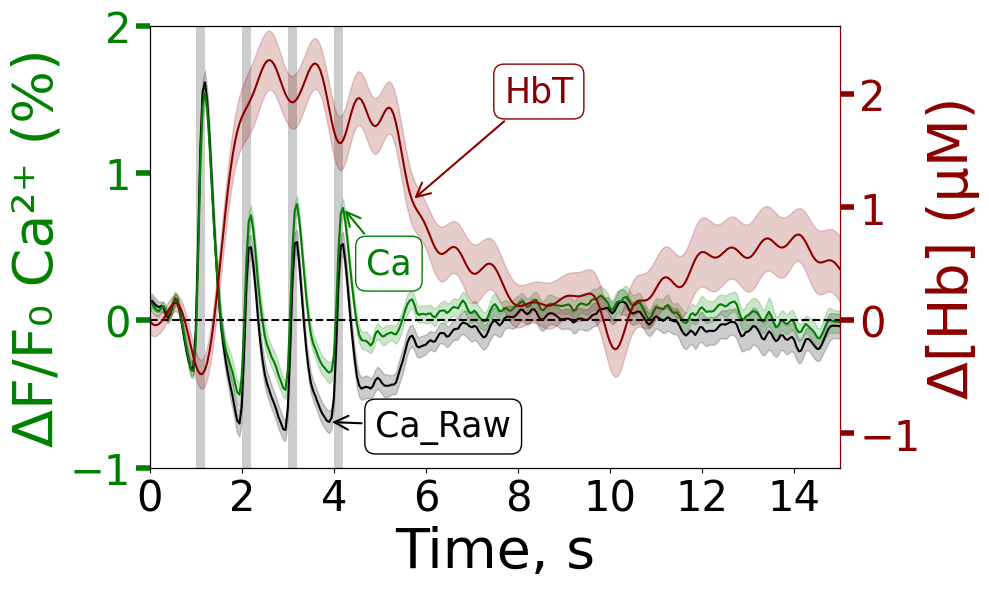

In [9]:
# Сolor dictionary
color_dict = {
    'Ca_Raw': 'black',
    'Ca': 'green',
    'HbT': 'darkred',
    'HbO': 'red',
    'HbR': 'blue'
}

# Example vertical label placement fractions
label_y_fracs = {
    'Ca_Raw': 0.08,
    'Ca': 0.48,
    'HbT': 0.8,
    'HbO': 0.45,
    'HbR': 0.25
}

# Example horizontal label placement fractions (time-based)
label_x_fracs = {
    'Ca_Raw': 0.26,   
    'Ca': 0.28,  
    'HbT': 0.38,
    'HbO': 0.4,
    'HbR': 0.7
}

# Time offsets (in seconds) for label placement
x_offsets_sec= {
    'Ca_Raw': 1,
    'Ca': 0.5,
    'HbT': 2,
    'HbO': -4,
    'HbR': 5
}

stim_type = 'V'

# Call the plotting function
plot_single_panel_signals_df(
    data_for_plot_fn_ca=data_for_plot_fn_ca,
    data_for_plot_fn_hbt=data_for_plot_fn_hbt,
    ca_df=cawocorr_df,           # DataFrame with raw Ca
    ca_corr_df=ca_df,            # DataFrame with corrected Ca
    dhbt_df=hbt_df,              # Sum of HbO and HbR
    dhbo_df=None,                # Optional
    dhbr_df=None,                # Optional
    stim_type=stim_type,
    state='Awake',
    annotate_stimulus=False,
    stim_label='Stimulus',
    x_label='Time, s',
    y_ca='ΔF/F₀ Ca²⁺ (%)',
    y_hb='Δ[Hb] (μM)',
    label_position='center',
    error_type='se',
    exclude_mice=[],
    color_dict=color_dict,
    error_alpha=0.2,
    y1_color='green',
    y2_color='darkred',
    y1_label_color='green',
    y2_label_color='darkred',
    label_y_fracs=label_y_fracs,
    label_x_fracs=label_x_fracs,
    # y1_lim=(-1, 2),
    # y2_lim=(-6, 12),
    y1_lim=(-1, 2),
    y2_lim=(-3/2.303, 6/2.303),
    x_lim=(0, 15), 
    x_offsets_sec=x_offsets_sec,
    ann_fontsize=25,
    save_path=Path(r'D:\Methods_figures') / f'{stim_type}_article_upd',
    x_tick_step=2,        # X-axis tick step
    y1_tick_step=1,       # Y-axis tick step for Ca
    y2_tick_step=1        # Y-axis tick step for Hb
)

### Eyes

In [11]:
#
# Data loading
directory = Path(r'D:\Data_article\Eyes')

ca_df = pd.read_csv(directory / 'Ca_stim_info.csv')
cawocorr_df = pd.read_csv(directory / 'Cawocorr_stim_info.csv')
hbt_df = pd.read_csv(directory / 'dcHbT_stim_info.csv')
hbo_df = pd.read_csv(directory / 'dcHbO_stim_info.csv')
hbr_df = pd.read_csv(directory / 'dcHbR_stim_info.csv')

# Path to the behavioral annotation file
beh_path = directory / 'beh.xlsx'

# Merge with behavioral annotations
ca_df = merge_behavior_with_stim_data(ca_df, beh_path, behavior_sheet=0)
cawocorr_df = merge_behavior_with_stim_data(cawocorr_df, beh_path, behavior_sheet=0)
hbt_df = merge_behavior_with_stim_data(hbt_df, beh_path, behavior_sheet=0)
#hbo_df = merge_behavior_with_stim_data(hbo_df, beh_path, behavior_sheet=0)
#hbr_df = merge_behavior_with_stim_data(hbr_df, beh_path, behavior_sheet=0)

# Add response side information
response_side(ca_df)
response_side(cawocorr_df)
response_side(hbt_df)
#response_side(hbo_df)
#response_side(hbr_df)

# Filtering by parameters
# For example, by state
ca_df = ca_df.loc[ca_df.state == 'Awake']
cawocorr_df = cawocorr_df.loc[cawocorr_df.state == 'Awake']
hbt_df = hbt_df.loc[hbt_df.state == 'Awake']

# For example, by behavior
ca_df = ca_df.loc[ca_df.behavior == 's']
cawocorr_df = cawocorr_df.loc[cawocorr_df.behavior == 's']
hbt_df = hbt_df.loc[hbt_df.behavior == 's']

In [13]:
data_for_plot_fn_ca = partial(
    data_for_plot,
    detrend=True,
    detrend_s=1e6,
    detrend_time=15.0,
    detrend_threshold=-10/2.303,
    multiplier=100,
    multiplier2=1e6,
    baseline_frames=20
)

data_for_plot_fn_hbt = partial(
    data_for_plot,
    detrend=True,
    detrend_time=15.0,
    detrend_threshold=-10/2.303,
    detrend_s=1e6, 
    multiplier=1e6,
    multiplier2=1e6,
    baseline_frames=20,
    smoothing='savgol',
    smoothing_params={'window_length': 11, 'polyorder': 3}
)

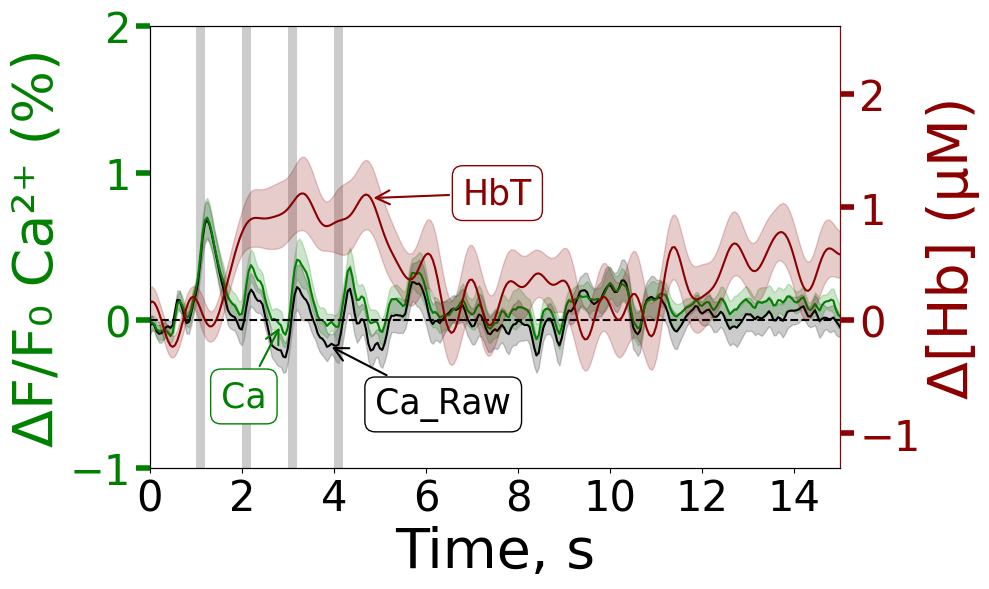

In [14]:
# Сolor dictionary
color_dict = {
    'Ca_Raw': 'black',
    'Ca': 'green',
    'HbT': 'darkred',
    'HbO': 'red',
    'HbR': 'blue'
}

# Example vertical label placement fractions
label_y_fracs = {
    'Ca_Raw': -0.08,
    'Ca': -0.04,
    'HbT': 0.8,
    'HbO': 0.45,
    'HbR': 0.25
}

# Example horizontal label placement fractions (time-based)
label_x_fracs = {
    'Ca_Raw': 0.26,           
    'Ca': 0.19,  
    'HbT': 0.32,
    'HbO': 0.4,
    'HbR': 0.7
}

# Time offsets (in seconds) for label placement
x_offsets_sec= {
    'Ca_Raw': 1,
    'Ca': -1.3,
    'HbT': 2,
    'HbO': -4,
    'HbR': 5
}

stim_type = 'E'

# Call the plotting function
plot_single_panel_signals_df(
    data_for_plot_fn_ca=data_for_plot_fn_ca,
    data_for_plot_fn_hbt=data_for_plot_fn_hbt,
    ca_df=cawocorr_df,           # DataFrame with raw Ca
    ca_corr_df=ca_df,            # DataFrame with corrected Ca
    dhbt_df=hbt_df,              # Sum of HbO and HbR
    dhbo_df=None,                # Optional
    dhbr_df=None,                # Optional
    stim_type=stim_type,
    state='Awake',
    annotate_stimulus=False,
    stim_label='Stimulus',
    x_label='Time, s',
    y_ca='ΔF/F₀ Ca²⁺ (%)',
    y_hb='Δ[Hb] (μM)',
    label_position='center',
    error_type='se',
    exclude_mice=[],
    color_dict=color_dict,
    error_alpha=0.2,
    y1_color='green',
    y2_color='darkred',
    y1_label_color='green',
    y2_label_color='darkred',
    label_y_fracs=label_y_fracs,
    label_x_fracs=label_x_fracs,
    # y1_lim=(-1, 2),
    # y2_lim=(-6, 12),
    y1_lim=(-1, 2),
    y2_lim=(-3/2.303, 6/2.303),
    x_lim=(0, 15), 
    x_offsets_sec=x_offsets_sec,
    ann_fontsize=25,
    save_path=Path(r'D:\Methods_figures') / f'{stim_type}_article_upd',
    x_tick_step=2,        # X-axis tick step
    y1_tick_step=1,       # Y-axis tick step for Ca
    y2_tick_step=1        # Y-axis tick step for Hb
)

### Hind limbs

In [15]:

# Data loading
directory = Path(r'D:\Data_article\Limbs')

ca_df = pd.read_csv(directory / 'Ca_stim_info.csv')
cawocorr_df = pd.read_csv(directory / 'Cawocorr_stim_info.csv')
hbt_df = pd.read_csv(directory / 'dcHbT_stim_info.csv')
hbo_df = pd.read_csv(directory / 'dcHbO_stim_info.csv')
hbr_df = pd.read_csv(directory / 'dcHbR_stim_info.csv')

# Path to the behavioral annotation file
beh_path = directory / 'beh.xlsx'

# Merge with behavioral annotations
ca_df = merge_behavior_with_stim_data(ca_df, beh_path, behavior_sheet=0)
cawocorr_df = merge_behavior_with_stim_data(cawocorr_df, beh_path, behavior_sheet=0)
hbt_df = merge_behavior_with_stim_data(hbt_df, beh_path, behavior_sheet=0)
#hbo_df = merge_behavior_with_stim_data(hbo_df, beh_path, behavior_sheet=0)
#hbr_df = merge_behavior_with_stim_data(hbr_df, beh_path, behavior_sheet=0)

# Add response side information
response_side(ca_df)
response_side(cawocorr_df)
response_side(hbt_df)
#response_side(hbo_df)
#response_side(hbr_df)

# Filtering by parameters
# For example, by state
ca_df = ca_df.loc[ca_df.state == 'Awake']
cawocorr_df = cawocorr_df.loc[cawocorr_df.state == 'Awake']
hbt_df = hbt_df.loc[hbt_df.state == 'Awake']

# For example, by behavior
ca_df = ca_df.loc[ca_df.behavior == 's']
cawocorr_df = cawocorr_df.loc[cawocorr_df.behavior == 's']
hbt_df = hbt_df.loc[hbt_df.behavior == 's']

In [16]:
data_for_plot_fn_ca = partial(
    data_for_plot,
    detrend=True,
    detrend_s=1e6,
    detrend_time=15.0,
    detrend_threshold=-10/2.303,
    multiplier=100,
    multiplier2=1e6,
    baseline_frames=20
)

data_for_plot_fn_hbt = partial(
    data_for_plot,
    detrend=True,
    detrend_time=15.0,
    detrend_threshold=-10/2.303,
    detrend_s=1e6, 
    multiplier=1e6,
    multiplier2=1e6,
    baseline_frames=20,
    smoothing='savgol',
    smoothing_params={'window_length': 11, 'polyorder': 3}
)

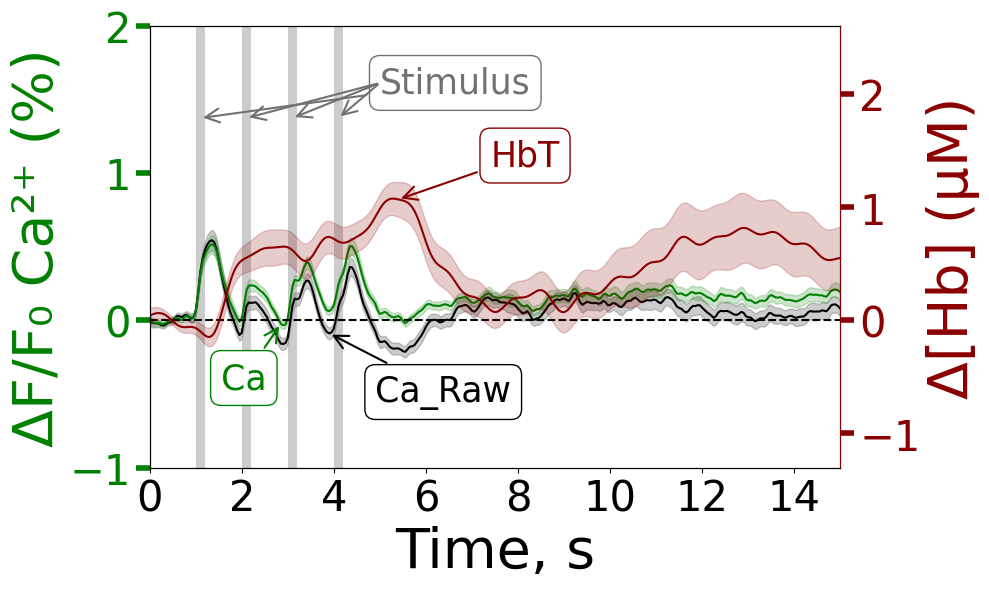

In [18]:
# Сolor dictionary
color_dict = {
    'Ca_Raw': 'black',
    'Ca': 'green',
    'HbT': 'darkred',
    'HbO': 'red',
    'HbR': 'blue'
}

# Example vertical label placement fractions
label_y_fracs = {
    'Ca_Raw': -0.2,
    'Ca': -0.1,
    'HbT': 1.1,
    'HbO': 0.45,
    'HbR': 0.25
}

# Example horizontal label placement fractions (time-based)
label_x_fracs = {
    'Ca_Raw': 0.26,      
    'Ca': 0.19,  
    'HbT': 0.36,
    'HbO': 0.4,
    'HbR': 0.7
}

# Time offsets (in seconds) for label placement
x_offsets_sec= {
    'Ca_Raw': 1,
    'Ca': -1.3,
    'HbT': 2,
    'HbO': -4,
    'HbR': 5
}

stim_type = 'HL'

# Call the plotting function
plot_single_panel_signals_df(
    data_for_plot_fn_ca=data_for_plot_fn_ca,
    data_for_plot_fn_hbt=data_for_plot_fn_hbt,
    ca_df=cawocorr_df,           # DataFrame with raw Ca
    ca_corr_df=ca_df,            # DataFrame with corrected Ca
    dhbt_df=hbt_df,              # Sum of HbO and HbR
    dhbo_df=None,                # Optional
    dhbr_df=None,                # Optional
    stim_type=stim_type,
    state='Awake',
    annotate_stimulus=True,
    stim_label='Stimulus',
    x_label='Time, s',
    y_ca='ΔF/F₀ Ca²⁺ (%)',
    y_hb='Δ[Hb] (μM)',
    label_position='center',
    error_type='se',
    exclude_mice=[],
    color_dict=color_dict,
    error_alpha=0.2,
    y1_color='green',
    y2_color='darkred',
    y1_label_color='green',
    y2_label_color='darkred',
    label_y_fracs=label_y_fracs,
    label_x_fracs=label_x_fracs,
    # y1_lim=(-1, 2),
    # y2_lim=(-6, 12),
    y1_lim=(-1, 2),
    y2_lim=(-3/2.303, 6/2.303),
    x_lim=(0, 15), 
    x_offsets_sec=x_offsets_sec,
    ann_fontsize=25,
    y_stim_ann = (1.75, 2),
    stim_box_x=5.0,
    save_path=Path(r'D:\Methods_figures') / f'{stim_type}_article_upd',
    x_tick_step=2,        # X-axis tick step
    y1_tick_step=1,       # Y-axis tick step for Ca
    y2_tick_step=1,        # Y-axis tick step for Hb
    stim_arrow_color='#727073',
    stim_box_edge_color='#727073',
    stim_box_face_color='white',
    stim_text_color='#727073',
)

# Parameter analysis for HL

In [19]:
# Load data
directory = Path(r'D:\Data_article\Limbs')

ca_df = pd.read_csv(directory / 'Ca_stim_info.csv')
cawocorr_df = pd.read_csv(directory / 'Cawocorr_stim_info.csv')
hbt_df = pd.read_csv(directory / 'dcHbT_stim_info.csv')
hbo_df = pd.read_csv(directory / 'dcHbO_stim_info.csv')
hbr_df = pd.read_csv(directory / 'dcHbR_stim_info.csv')

# Path to the behavior file
beh_path = Path(r'D:\Data_article\Limbs\beh.xlsx')

# Merge with behavioral annotations
ca_df = merge_behavior_with_stim_data(ca_df, beh_path, behavior_sheet=0)
cawocorr_df = merge_behavior_with_stim_data(cawocorr_df, beh_path, behavior_sheet=0)
hbt_df = merge_behavior_with_stim_data(hbt_df, beh_path, behavior_sheet=0)

In [20]:
summary_ca = summarize_stim_df(
    df=ca_df,
    df2=hbt_df,
    stim_window=(1,5),
    baseline_window=(0,1),
    smoothing='savgol',
    smoothing_params={'window_length':11,'polyorder':3},
    multiplier=100,
    multiplier2=1e6,
    detrend=True,
    detrend_s=1e6,
    baseline_frames=20,
    detrend_time=15,
    detrend_threshold=-10/2.303
)

summary_ca.head()

,signal,stim_type,hemisphere,state,exp,protocol,mouse,behavior,stim#,AUC,Max_Response,Detrend
0,Ca,HL,R,Awake,Before-PT,LHL-90mkA,m10j,t-st,st1,5.356588,5.075768,False
1,Ca,HL,R,Awake,Before-PT,LHL-90mkA,m10j,t,st2,0.749388,0.484169,True
2,Ca,HL,R,Awake,Before-PT,LHL-90mkA,m10j,s,st3,1.187027,0.769705,False
3,Ca,HL,R,Awake,Before-PT,LHL-90mkA,m10j,s-r,st4,2.239084,1.137957,False
4,Ca,HL,R,Awake,Before-PT,LHL-90mkA,m10j,s-r,st5,3.585919,2.817084,False


In [21]:
summary_hbt = summarize_stim_df(
    df=hbt_df,
    df2=hbt_df,
    stim_window=(1,12),
    baseline_window=(0,1),
    smoothing='savgol',
    smoothing_params={'window_length':40,'polyorder':3},
    multiplier=1e6,
    multiplier2=1e6,
    detrend=True,
    detrend_s=1e6,
    baseline_frames=20,
    detrend_time=15,
    detrend_threshold=-10/2.303
)

summary_hbt.head()

,signal,stim_type,hemisphere,state,exp,protocol,mouse,behavior,stim#,AUC,Max_Response,Detrend
0,dcHbT,HL,R,Awake,Before-PT,LHL-90mkA,m10j,t-st,st1,84.740614,15.760131,False
1,dcHbT,HL,R,Awake,Before-PT,LHL-90mkA,m10j,t,st2,-3.586782,0.327406,True
2,dcHbT,HL,R,Awake,Before-PT,LHL-90mkA,m10j,s,st3,37.721798,15.734199,False
3,dcHbT,HL,R,Awake,Before-PT,LHL-90mkA,m10j,s-r,st4,55.811734,12.692224,False
4,dcHbT,HL,R,Awake,Before-PT,LHL-90mkA,m10j,s-r,st5,52.678532,11.112339,False


In [32]:
stats_table_ca = descriptive_stats_table(summary_ca, metrics=['AUC', 'Max_Response'])
stats_table_ca

25%                    50%                    75%  \
                  AUC Max_Response       AUC Max_Response       AUC   
category                                                              
Awake_other  1.602355     2.421058  3.231797     3.352121  5.221981   
Awake_s      0.175283     0.551282  0.844650     0.945357  1.509213   
Iso         -0.712864     1.298661  0.443623     1.720865  1.658559   

                          count                    max                   mean  \
            Max_Response    AUC Max_Response       AUC Max_Response       AUC   
category                                                                        
Awake_other     4.155818  232.0        232.0  9.475798     7.135467  3.159493   
Awake_s         1.443138  146.0        146.0  3.984222     3.749613  0.897270   
Iso             2.360328  378.0        378.0  7.729540     4.252685  0.469187   

                               min                    std               
            Max_Response       AUC Max_Response       AUC Max_Response  
category                                                                
Awake_other     3.145249 -6.677256    -0.622097  2.834737     1.476553  
Awake_s         1.143739 -2.533390    -0.253628  1.109786     0.805430  
Iso             1.830654 -6.565708    -0.164519  1.897039     0.760257

In [22]:
stats_table_hbt = descriptive_stats_table(summary_hbt, metrics=['AUC', 'Max_Response'])
stats_table_hbt

25%                     50%                     75%  \
                  AUC Max_Response        AUC Max_Response        AUC   
category                                                                
Awake_other  4.494212     4.662026  48.558157    11.134070  87.680814   
Awake_s     -4.428994     1.013978   2.744717     1.764196  11.839335   

                          count                      max               \
            Max_Response    AUC Max_Response         AUC Max_Response   
category                                                                
Awake_other    15.636271  232.0        232.0  166.391717    26.228724   
Awake_s         3.059117  146.0        146.0   71.428426    22.300159   

                  mean                     min                     std  \
                   AUC Max_Response        AUC Max_Response        AUC   
category                                                                 
Awake_other  48.913120    10.686849 -75.693395    -0.924425  50.140955   
Awake_s       5.105992     2.927634 -29.515949    -0.851301  15.197148   

                          
            Max_Response  
category                  
Awake_other     6.698579  
Awake_s         3.667177

In [23]:
summary_ca = make_category(summary_ca)
result = compare_two_groups(
    summary_ca,
    category_col='category',
    metric='AUC',
    group1='Awake_s',
    group2='Awake_other'
)
print(result['text'])

summary_hbt = make_category(summary_hbt)
result = compare_two_groups(
    summary_hbt,
    category_col='category',
    metric='AUC',
    group1='Awake_s',
    group2='Awake_other'
)
print(result['text'])

In group 'Awake_s' (M=0.90, SD=1.11, n=146) and group 'Awake_other' (M=3.16, SD=2.83, n=232), Levene's test indicated unequal variances (F=71.67, p=0.000). We therefore used the Welch t-test, which gave t(326.4) = -10.90, p = 0.000, Cohen's d = -0.97.
In group 'Awake_s' (M=5.11, SD=15.20, n=146) and group 'Awake_other' (M=48.91, SD=50.14, n=232), Levene's test indicated unequal variances (F=173.63, p=0.000). We therefore used the Welch t-test, which gave t(293.4) = -12.43, p = 0.000, Cohen's d = -1.08.


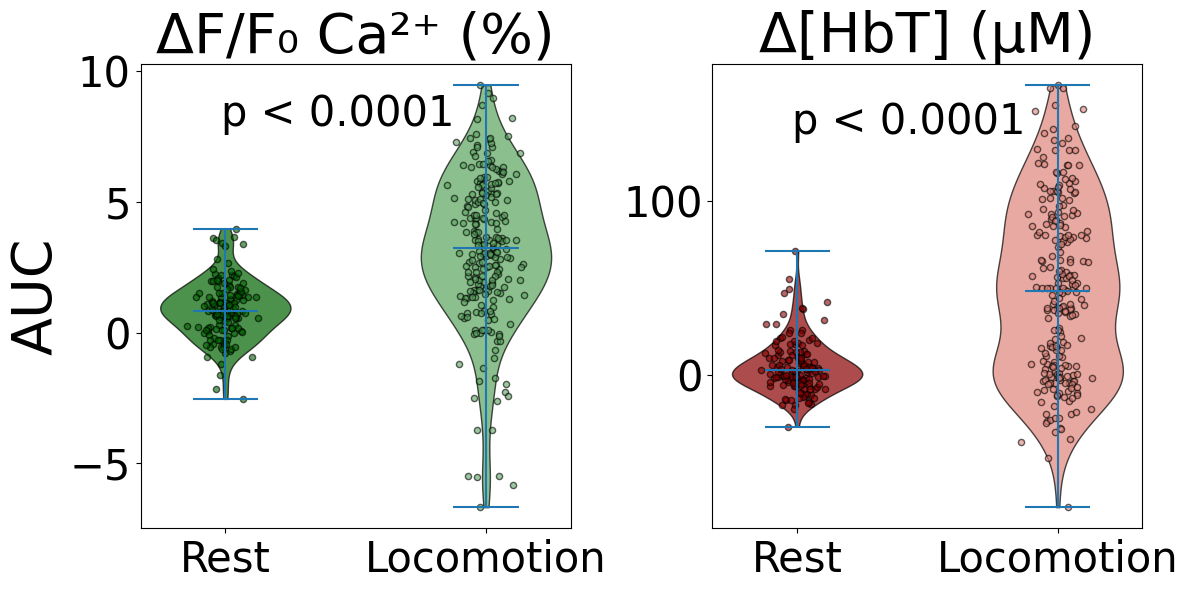

In [24]:
plot_side_by_side_violins(
    summary_ca,
    summary_hbt,
    metric='AUC',
    categories=['Awake_s', 'Awake_other'],
    colors_ca={'Awake_s': 'darkgreen', 'Awake_other': '#5aa45f'},
    colors_hbt={'Awake_s': 'darkred', 'Awake_other': '#de857a'},
    subtitle_ca='ΔF/F₀ Ca²⁺ (%)',
    subtitle_hbt='Δ[HbT] (μM)',
    scatter_edgecolor='k',
    fontsize={'title': BIGGER_SIZE, 'label': BIGGER_SIZE, 'ticks': SMALL_SIZE, 'p': SMALL_SIZE},
    p_value_offset=0.8,
    category_labels={'Awake_s': 'Rest', 'Awake_other': 'Locomotion'},
    save_fig_path = 'D:\\Methods_figures\\Stat_HL_article_upd.png'
)

# Plot response rest vs locomotion

In [25]:
# Load data
directory = Path(r'D:\Data_article\Limbs')

ca_df = pd.read_csv(directory / 'Ca_stim_info.csv')
cawocorr_df = pd.read_csv(directory / 'Cawocorr_stim_info.csv')
hbt_df = pd.read_csv(directory / 'dcHbT_stim_info.csv')
hbo_df = pd.read_csv(directory / 'dcHbO_stim_info.csv')
hbr_df = pd.read_csv(directory / 'dcHbR_stim_info.csv')

# Path to the behavior file
beh_path = Path(r'D:\Data_article\Limbs\beh.xlsx')

# Merge with behavioral annotations
ca_df = merge_behavior_with_stim_data(ca_df, beh_path, behavior_sheet=0)
cawocorr_df = merge_behavior_with_stim_data(cawocorr_df, beh_path, behavior_sheet=0)
hbt_df = merge_behavior_with_stim_data(hbt_df, beh_path, behavior_sheet=0)

response_side(ca_df)
response_side(cawocorr_df)
response_side(hbt_df)
#response_side(hbo_df)
#response_side(hbr_df)

In [26]:
# Filtering by parameters
# For example, by state
ca_df = ca_df.loc[ca_df.state == 'Awake']
cawocorr_df = cawocorr_df.loc[cawocorr_df.state == 'Awake']
hbt_df = hbt_df.loc[hbt_df.state == 'Awake']

# For example, by behavior
ca_df_s = ca_df.loc[ca_df.behavior == 's']
cawocorr_df_s = cawocorr_df.loc[cawocorr_df.behavior == 's']
hbt_df_s = hbt_df.loc[hbt_df.behavior == 's']
ca_df_l = ca_df.loc[ca_df.behavior != 's']
cawocorr_df_l = cawocorr_df.loc[cawocorr_df.behavior != 's']
hbt_df_l = hbt_df.loc[hbt_df.behavior != 's']

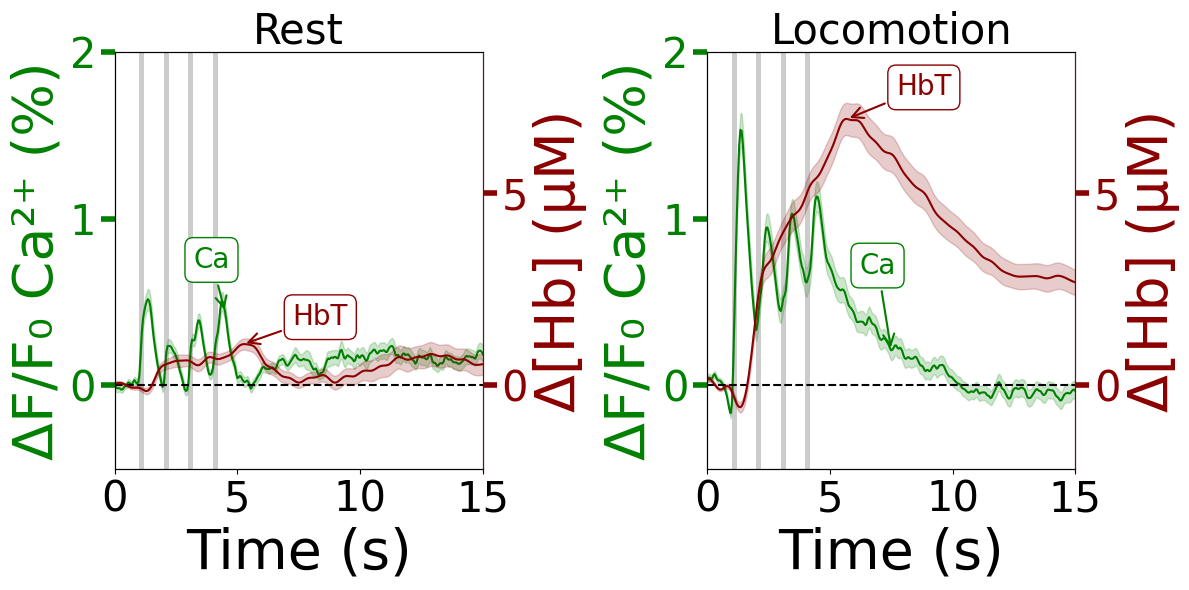

In [36]:
plot_dual_panel_signals_df(
    left_data={
        'ca_df': None,
        'ca_corr_df': ca_df_s,
        'dhbt_df': hbt_df_s,
        'label_y_fracs': {
            'Ca_Raw': 0.7,
            'Ca': 1.2,
            'HbT': 1.3,
            'HbO': 0.45,
            'HbR': 0.25
        }, 
        'label_x_fracs': {
            'Ca_Raw': 0.2,
            'Ca': 0.3,
            'HbT': 0.35,
            'HbO': 0.4,
            'HbR': 0.7
        }   
    },
    right_data={
        'ca_df': None,
        'ca_corr_df': ca_df_l,
        'dhbt_df': hbt_df_l,
        'label_y_fracs': {
            'Ca_Raw': 0.7,
            'Ca': 0.5,
            'HbT': 1,
            'HbO': 0.45,
            'HbR': 0.25
        }, 
        'label_x_fracs': {
            'Ca_Raw': 0.2,
            'Ca': 0.5,
            'HbT': 0.38,
            'HbO': 0.4,
            'HbR': 0.7
        }   
    },
    data_for_plot_fn_ca=data_for_plot_fn_ca,
    data_for_plot_fn_hbt=data_for_plot_fn_hbt,
    left_title="Rest",
    right_title="Locomotion",
    stim_type='HL',
    state='Awake',
    y1_lim=(-0.5, 2),
    y2_lim=(-5/2.303, 20/2.303),
    x_lim=(0, 15),
    y1_color='green',
    y2_color='darkred',
    y1_label_color='green',
    y2_label_color='darkred',
    error_type='se',
    error_alpha=0.2,
    ann_fontsize=20,
    x_tick_step=5,
    y1_tick_step=1,
    y2_tick_step=5,
    label_y_fracs = label_y_fracs,
    label_x_fracs = label_x_fracs,
    x_offsets_sec = x_offsets_sec,
    stim_box_x = 4.5,
    annotate_stimulus = False,
    figsize = (12, 6),
    save_path = Path(r'D:\Methods_figures')/f'HL_res_vs_loc_article_upd'

    
)